In [1]:
import importlib

import dataset, metrics, plotting, config, network
from models import cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

Using TensorFlow backend.
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

<module 'models.cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/ganRegression/models/cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="hdpe")

assert(dataset_config.scenario == "magical_sinus"
      or dataset_config.scenario == "hdpe")
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/hdpe already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.0001,
                             optim_gen="Adam", optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_samples=500),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [5]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(scenario=exp_config.dataset.scenario,
                                                                         seed=exp_config.model.random_seed)

In [6]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.fit_transform(X_valid)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = y_scaler.fit_transform(y_valid.reshape(-1, 1))

## Gaussian Process

In [7]:
import GPy

variance = 0.1
length = 1

kernel = GPy.kern.RBF(input_dim=15, variance=variance, lengthscale=length)
gpr = GPy.models.GPRegression(X_train_scaled, y_train_scaled, kernel)

run_hyperopt_search = True
if run_hyperopt_search:
    gpr.optimize(messages=True)

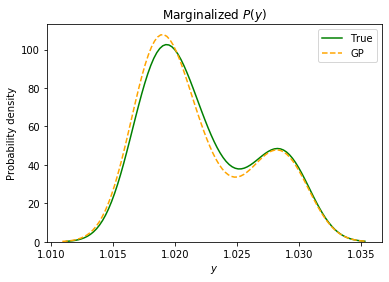

In [8]:
ypred_gp_val, cov = gpr.predict(X_valid_scaled)
plotting.plot_densities_joint(y_valid, None, None, y_scaler.inverse_transform(ypred_gp_val),
                             title=f"Marginalized $P(y)$", fig_dir=fig_dir,
                             prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

##  CGAN

In [9]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train_scaled, y_train_scaled,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=False)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 15)           0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 60)           960         Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 60)           360         Generator_input_z[0][0] 

 /Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/keras/engine/training.py:493: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


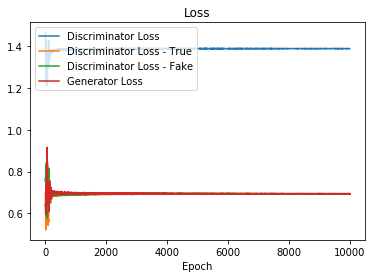

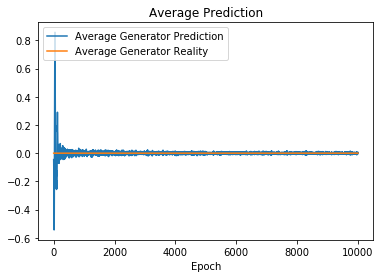

In [10]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## CVT samples: taking as input parts of a paired virtual  samples.

In [11]:
from os.path import basename
X_cvt = np.load(f"{fig_dir}/{basename(fig_dir)}_CVT_samples.npy")
X_cvt_scaled = X_scaler.transform(X_cvt)

In [12]:
ypred_cvt, _, _ = cgan.sample(X_cvt_scaled, exp_config.training.n_samples)

In [13]:
ypred_cvt = y_scaler.inverse_transform(ypred_cvt)

In [15]:
X_cvt_paird = np.c_[X_cvt, ypred_cvt]

In [17]:
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_CVT_samples_paired.npy", X_cvt_paird)
